In [1]:
# rbm-recommender.ipynb

In [2]:
import ipykernel
import numpy as np

In [3]:
!conda info|find "active environment"

     active environment : base


In [4]:
import sys
#import os
#os.chdir('..')
import pandas as pd
import tensorflow as tf
import time
tf.get_logger().setLevel('ERROR') # only show error messages
import random
from tqdm.notebook import tqdm
from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph
from user_func import toratings, prdf
from IPython.display import Markdown
import matplotlib.pyplot as plt
from importlib import reload
from settings import *

#For interactive mode only
%load_ext autoreload
%autoreload 2
%matplotlib inline

print(f'System version: {sys.version}')
print(f'Pandas version: {pd.__version__}')
print(f'Tensorflow version: {tf.__version__}')

System version: 3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.5.3
Tensorflow version: 2.16.1


In [5]:
start_time = time.time()

## Load data

In [7]:
pd.options.display.float_format = "{:,.2f}".format

In [8]:
while not showcase_seg_file.is_file():
    time.sleep(30)
dataset = pd.read_pickle(ds_flt_file) # Полные данные после фильтрации
df = pd.read_pickle(showcase_seg_file) # Сегментированная витрина
#df = df.sample(n=df.shape[0], random_state=44)


#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "itemID",
        "col_rating": "rating",
    }

# number of top score elements to be recommended  
K = 50

In [9]:
ds_flt_file.is_file()

True

In [10]:
def load_data(seg):
    ds = toratings(df[df['Segment']==seg], dataset, False) # Отстутствие покупки попадает в список с 0 рейтингом
    data = ds[['userID', 'itemID', 'rating']]
    return ds

In [11]:
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
        }, 
        index=[0]
    )
    
    return df_result

Took 11.12 seconds for training.


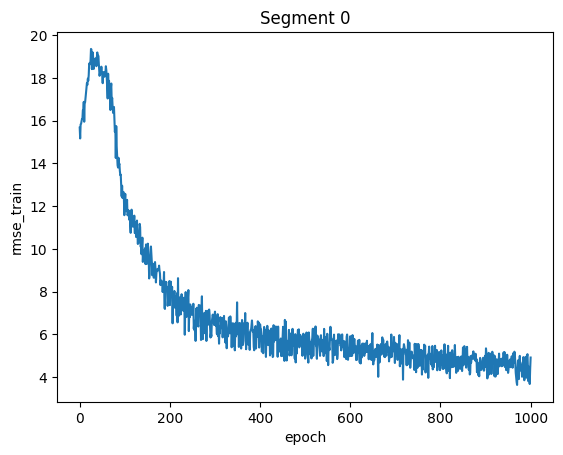

Took 0.14 seconds for prediction.

Сегмент: 0
Пользователь: 560178807
Рекомендовано: ['iron', 'painting', 'video', 'cooler', 'toilet']
Куплено: {'headphone', 'notebook', 'microwave'}

Пользователь: 548366534
Рекомендовано: ['iron', 'painting', 'toilet', 'cooler', 'kettle']
Куплено: {'tv', 'microwave'}

Пользователь: 556212053
Рекомендовано: ['painting', 'toilet', 'microwave', 'carriage', 'shirt']
Куплено: {'subwoofer'}

Пользователь: 525629565
Рекомендовано: ['iron', 'painting', 'video', 'shirt', 'cooler']
Куплено: {'water_heater'}

Пользователь: 513923282
Рекомендовано: ['iron', 'shirt', 'painting', 'carriage', 'alarm']
Куплено: {'headphone', 'subwoofer'}

Пользователь: 531767884
Рекомендовано: ['iron', 'toilet', 'painting', 'video', 'cooler']
Куплено: {'notebook', 'microphone'}

Пользователь: 538636651
Рекомендовано: ['iron', 'toilet', 'painting', 'faucet', 'alarm']
Куплено: {'notebook', 'desktop'}

Пользователь: 512723129
Рекомендовано: ['iron', 'shirt', 'cooler', 'carriage', 'toile

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 0,5,0.09,0.09,0.02,0.10


---

Took 34.36 seconds for training.


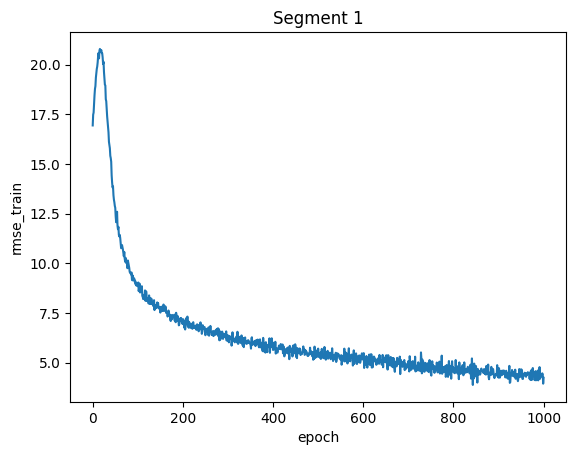

Took 0.19 seconds for prediction.

Сегмент: 1
Пользователь: 512438522
Рекомендовано: ['tshirt', 'sandals', 'fan', 'shirt', 'tennis']
Куплено: {'headphone', 'desktop'}

Пользователь: 514327423
Рекомендовано: ['headphone', 'tshirt', 'sandals', 'shirt', 'fan']
Куплено: {'ebooks'}

Пользователь: 520459913
Рекомендовано: ['tshirt', 'shirt', 'tennis', 'sandals', 'fan']
Куплено: {'tv'}

Пользователь: 514376249
Рекомендовано: ['headphone', 'tshirt', 'tennis', 'shirt', 'fan']
Куплено: {'tv', 'refrigerators'}

Пользователь: 523793383
Рекомендовано: ['cabinet', 'shoes', 'tshirt', 'shirt', 'fan']
Куплено: {'blender'}

Пользователь: 566464235
Рекомендовано: ['table', 'headphone', 'tshirt', 'tennis', 'shirt']
Куплено: {'tv', 'table', 'vacuum'}

Пользователь: 559009254
Рекомендовано: ['headphone', 'cabinet', 'tshirt', 'scarf', 'tennis']
Куплено: {'blender'}

Пользователь: 512783408
Рекомендовано: ['headphone', 'tshirt', 'fan', 'sandals', 'tennis']
Куплено: {'faucet'}

Пользователь: 557567229
Рекоменд

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 1,5,0.20,0.21,0.04,0.22


---

Took 8.43 seconds for training.


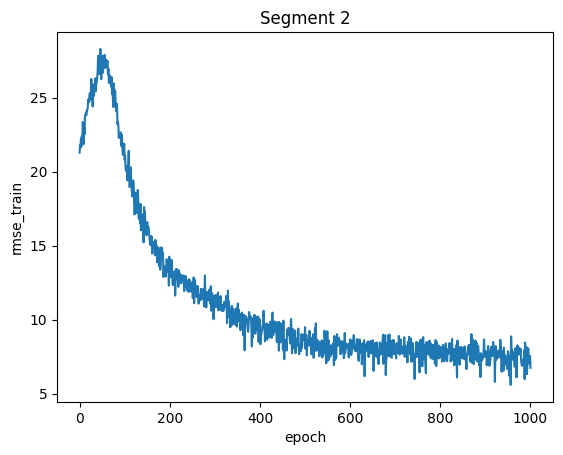

Took 0.13 seconds for prediction.

Сегмент: 2
Пользователь: 515496498
Рекомендовано: ['slipons', 'trainer', 'power_supply', 'keyboard', 'tonometer']
Куплено: {'ironing_board', 'cpu'}

Пользователь: 530778950
Рекомендовано: ['slipons', 'dress', 'keyboard', 'trainer', 'power_supply']
Куплено: {'headphone', 'washer'}

Пользователь: 516489419
Рекомендовано: ['slipons', 'welding', 'cartrige', 'trainer', 'cpu']
Куплено: {'keyboard'}

Пользователь: 520445563
Рекомендовано: ['slipons', 'trainer', 'keyboard', 'power_supply', 'welding']
Куплено: {'headphone', 'mouse'}

Пользователь: 554775457
Рекомендовано: ['slipons', 'power_supply', 'keyboard', 'welding', 'trainer']
Куплено: {'headphone', 'hdd'}

Пользователь: 513511867
Рекомендовано: ['slipons', 'trainer', 'keyboard', 'power_supply', 'welding']
Куплено: {'hdd'}

Пользователь: 552458546
Рекомендовано: ['slipons', 'power_supply', 'trainer', 'welding', 'keyboard']
Куплено: {'memory', 'hdd', 'cpu', 'motherboard'}

Пользователь: 515992179
Рекоменд

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 2,5,0.09,0.10,0.03,0.14


---

Took 103.39 seconds for training.


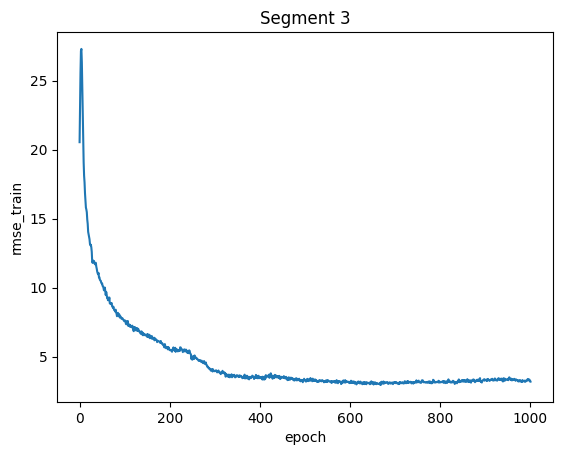

Took 0.23 seconds for prediction.

Сегмент: 3
Пользователь: 516121944
Рекомендовано: ['clocks', 'vacuum', 'hdd', 'mouse', 'bag']
Куплено: {'headphone', 'tv'}

Пользователь: 524143654
Рекомендовано: ['vacuum', 'hdd', 'bag', 'mouse', 'microwave']
Куплено: {'clocks'}

Пользователь: 519325021
Рекомендовано: ['clocks', 'vacuum', 'hdd', 'bag', 'mouse']
Куплено: {'headphone'}

Пользователь: 527784137
Рекомендовано: ['clocks', 'vacuum', 'hdd', 'bag', 'microwave']
Куплено: {'notebook'}

Пользователь: 560000818
Рекомендовано: ['clocks', 'vacuum', 'hdd', 'bag', 'mouse']
Куплено: {'headphone'}

Пользователь: 557604369
Рекомендовано: ['vacuum', 'hdd', 'mouse', 'bag', 'microwave']
Куплено: {'headphone'}

Пользователь: 524046667
Рекомендовано: ['clocks', 'vacuum', 'hdd', 'mouse', 'bag']
Куплено: {'headphone'}

Пользователь: 514033319
Рекомендовано: ['clocks', 'vacuum', 'hdd', 'mouse', 'microwave']
Куплено: {'notebook'}

Пользователь: 534116409
Рекомендовано: ['clocks', 'vacuum', 'hdd', 'mouse', 'bag'

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 3,5,0.27,0.29,0.07,0.35


---

Took 12.22 seconds for training.


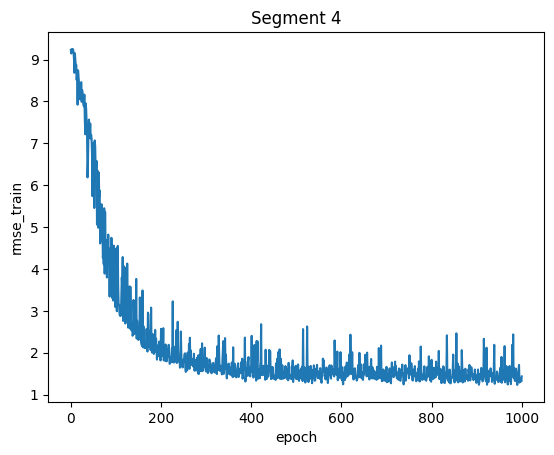

Took 0.11 seconds for prediction.

Сегмент: 4
Пользователь: 512592316
Рекомендовано: ['cultivator', 'swing', 'microwave', 'steam_cooker', 'video']
Куплено: {'headphone', 'clocks', 'grill'}

Пользователь: 522852807
Рекомендовано: ['cultivator', 'meat_grinder', 'steam_cooker', 'swing', 'microwave']
Куплено: {'headphone', 'meat_grinder', 'kettle'}

Пользователь: 522178482
Рекомендовано: ['cultivator', 'table', 'swing', 'steam_cooker', 'microwave']
Куплено: {'juicer', 'blender'}

Пользователь: 529967071
Рекомендовано: ['cultivator', 'table', 'swing', 'steam_cooker', 'microwave']
Куплено: {'oven', 'mixer'}

Пользователь: 564133992
Рекомендовано: ['cultivator', 'table', 'swing', 'steam_cooker', 'microwave']
Куплено: {'clocks', 'desktop'}

Пользователь: 548082646
Рекомендовано: ['cultivator', 'swing', 'steam_cooker', 'microwave', 'massager']
Куплено: {'oven', 'blender', 'kettle', 'headphone', 'washer', 'refrigerators'}

Пользователь: 559993619
Рекомендовано: ['cultivator', 'swing', 'steam_coo

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 4,5,0.12,0.13,0.03,0.17


---

Took 4.95 seconds for training.


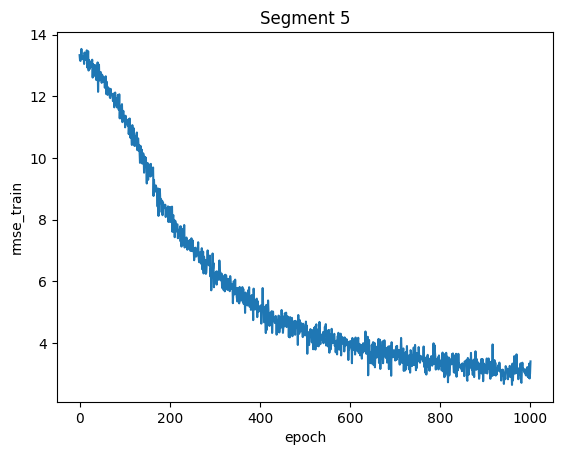

Took 0.14 seconds for prediction.

Сегмент: 5
Пользователь: 528013462
Рекомендовано: ['sandals', 'welding', 'toys', 'player', 'kettle']
Куплено: {'generator', 'washer', 'pump', 'saw'}

Пользователь: 513700408
Рекомендовано: ['sandals', 'blender', 'player', 'washer', 'chair']
Куплено: {'hood', 'telephone'}

Пользователь: 559787433
Рекомендовано: ['sandals', 'welding', 'blender', 'toys', 'player']
Куплено: {'dishwasher', 'hood', 'washer', 'refrigerators'}

Пользователь: 547781123
Рекомендовано: ['sandals', 'welding', 'washer', 'subwoofer', 'pump']
Куплено: {'tablet', 'tv', 'oven', 'microwave'}

Пользователь: 521025518
Рекомендовано: ['sandals', 'blender', 'washer', 'kettle', 'notebook']
Куплено: {'tv', 'air_conditioner'}

Пользователь: 543732962
Рекомендовано: ['sandals', 'welding', 'blender', 'washer', 'kettle']
Куплено: {'air_conditioner'}

Пользователь: 517028828
Рекомендовано: ['sandals', 'welding', 'washer', 'saw', 'hood']
Куплено: {'clocks', 'telephone', 'tablet', 'dishwasher'}

По

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 5,5,0.10,0.12,0.04,0.18


---

Took 58.47 seconds for training.


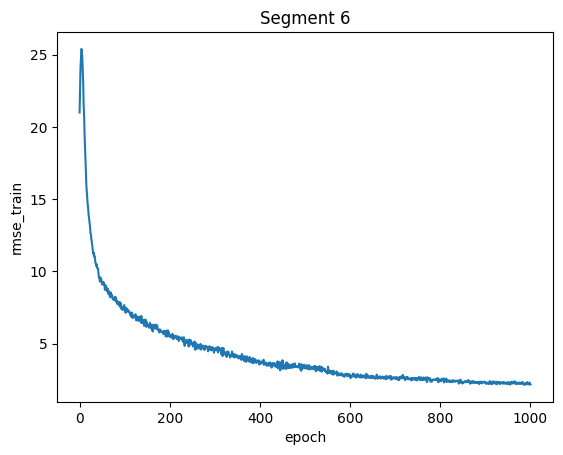

Took 0.18 seconds for prediction.

Сегмент: 6
Пользователь: 555842087
Рекомендовано: ['microwave', 'sewing_machine', 'diapers', 'grill', 'kettle']
Куплено: {'washer'}

Пользователь: 550151860
Рекомендовано: ['microwave', 'diapers', 'kettle', 'grill', 'bed']
Куплено: {'sewing_machine', 'tv'}

Пользователь: 533790237
Рекомендовано: ['sewing_machine', 'microwave', 'diapers', 'kettle', 'grill']
Куплено: {'tv', 'vacuum'}

Пользователь: 521369830
Рекомендовано: ['microwave', 'sewing_machine', 'diapers', 'grill', 'kettle']
Куплено: {'washer'}

Пользователь: 517695144
Рекомендовано: ['sewing_machine', 'diapers', 'kettle', 'grill', 'bed']
Куплено: {'microwave'}

Пользователь: 532434342
Рекомендовано: ['sewing_machine', 'microwave', 'diapers', 'kettle', 'grill']
Куплено: {'vacuum'}

Пользователь: 529259193
Рекомендовано: ['sewing_machine', 'microwave', 'diapers', 'kettle', 'grill']
Куплено: {'washer'}

Пользователь: 560874939
Рекомендовано: ['sewing_machine', 'diapers', 'kettle', 'grill', 'bed']

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 6,5,0.09,0.10,0.03,0.14


---

Took 11.36 seconds for training.


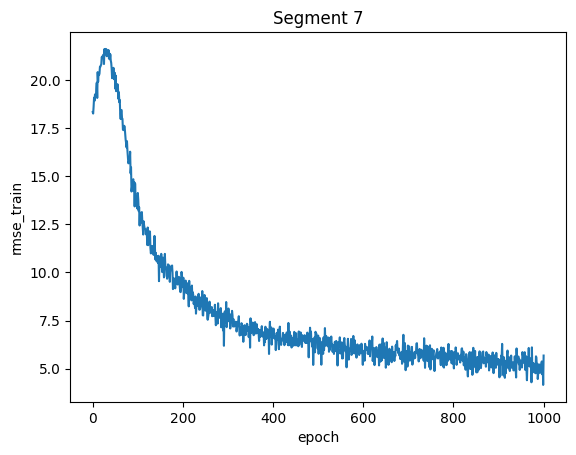

Took 0.14 seconds for prediction.

Сегмент: 7
Пользователь: 561404509
Рекомендовано: ['power_supply', 'bicycle', 'light', 'compressor', 'costume']
Куплено: {'notebook', 'piano'}

Пользователь: 551140089
Рекомендовано: ['power_supply', 'bicycle', 'light', 'bag', 'keds']
Куплено: {'clocks', 'tablet', 'toster', 'tv', 'player'}

Пользователь: 559341333
Рекомендовано: ['power_supply', 'light', 'compressor', 'bicycle', 'painting']
Куплено: {'diapers', 'desktop', 'vacuum'}

Пользователь: 514212541
Рекомендовано: ['power_supply', 'light', 'bicycle', 'compressor', 'moccasins']
Куплено: {'clocks', 'drill'}

Пользователь: 559723291
Рекомендовано: ['power_supply', 'bicycle', 'light', 'compressor', 'keds']
Куплено: {'player', 'videoregister'}

Пользователь: 543485473
Рекомендовано: ['power_supply', 'light', 'bicycle', 'compressor', 'bag']
Куплено: {'radar', 'videoregister'}

Пользователь: 513493916
Рекомендовано: ['power_supply', 'light', 'bicycle', 'compressor', 'painting']
Куплено: {'headphone', 

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 7,5,0.04,0.05,0.01,0.07


---

Took 15.62 seconds for training.


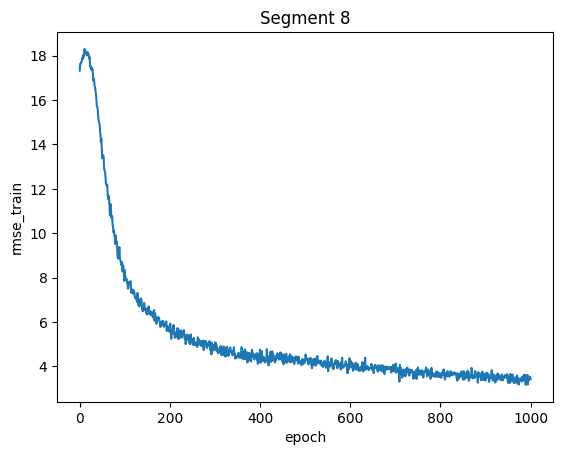

Took 0.13 seconds for prediction.

Сегмент: 8
Пользователь: 548877123
Рекомендовано: ['cultivator', 'table', 'toster', 'bed', 'wallet']
Куплено: {'printer', 'videoregister'}

Пользователь: 564032718
Рекомендовано: ['cultivator', 'blender', 'toster', 'bed', 'tshirt']
Куплено: {'printer', 'refrigerators'}

Пользователь: 543396419
Рекомендовано: ['cultivator', 'table', 'blender', 'toster', 'bed']
Куплено: {'scales'}

Пользователь: 551377632
Рекомендовано: ['cultivator', 'table', 'toster', 'bed', 'wallet']
Куплено: {'shoes', 'air_heater'}

Пользователь: 549282495
Рекомендовано: ['table', 'toster', 'bed', 'wallet', 'coffee_grinder']
Куплено: {'kettle', 'washer'}

Пользователь: 541422086
Рекомендовано: ['cultivator', 'table', 'toster', 'bed', 'wallet']
Куплено: {'iron', 'ironing_board'}

Пользователь: 558397001
Рекомендовано: ['cultivator', 'table', 'bed', 'toster', 'projector']
Куплено: {'printer'}

Пользователь: 519269263
Рекомендовано: ['cultivator', 'table', 'toster', 'bed', 'wallet']
Ку

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 8,5,0.03,0.03,0.01,0.05


---

Took 23.91 seconds for training.


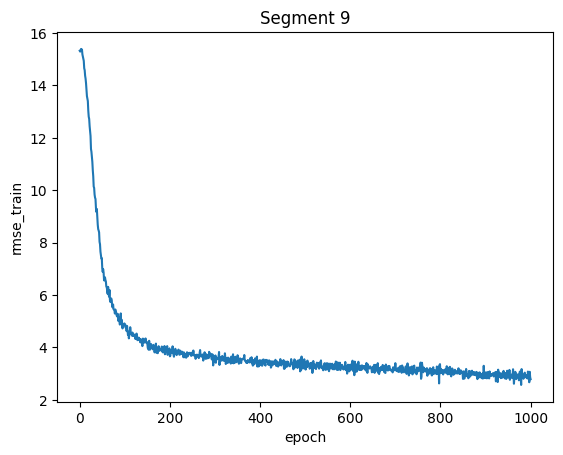

Took 0.13 seconds for prediction.

Сегмент: 9
Пользователь: 516006740
Рекомендовано: ['printer', 'monitor', 'telephone', 'alarm', 'welding']
Куплено: {'mixer'}

Пользователь: 516610377
Рекомендовано: ['monitor', 'telephone', 'alarm', 'bed', 'welding']
Куплено: {'iron', 'meat_grinder'}

Пользователь: 512483230
Рекомендовано: ['printer', 'monitor', 'telephone', 'alarm', 'bed']
Куплено: {'headphone', 'player'}

Пользователь: 556065041
Рекомендовано: ['printer', 'monitor', 'tv', 'alarm', 'welding']
Куплено: {'tablet', 'keds', 'washer'}

Пользователь: 522711943
Рекомендовано: ['monitor', 'telephone', 'alarm', 'bed', 'radar']
Куплено: {'blender', 'mixer'}

Пользователь: 513053419
Рекомендовано: ['printer', 'monitor', 'telephone', 'tv', 'alarm']
Куплено: {'iron', 'keds'}

Пользователь: 536895722
Рекомендовано: ['printer', 'monitor', 'telephone', 'alarm', 'bed']
Куплено: {'mixer'}

Пользователь: 514257075
Рекомендовано: ['monitor', 'alarm', 'bed', 'welding', 'radar']
Куплено: {'telephone', 'pl

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 9,5,0.05,0.07,0.03,0.13


---

Took 5.76 seconds for training.


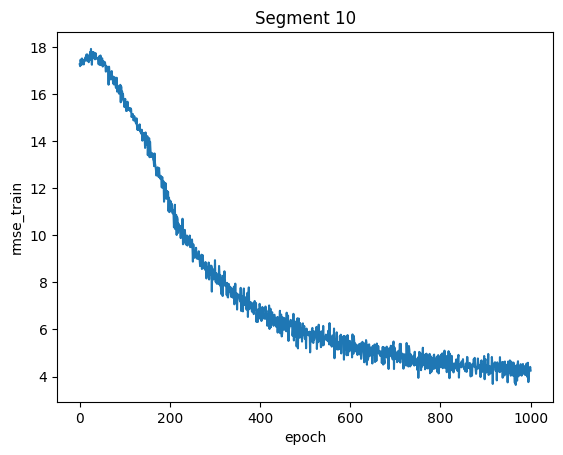

Took 0.12 seconds for prediction.

Сегмент: 10
Пользователь: 552787959
Рекомендовано: ['video', 'photo', 'player', 'blanket', 'iron']
Куплено: {'sewing_machine', 'blender'}

Пользователь: 566267483
Рекомендовано: ['video', 'photo', 'player', 'blanket', 'dishwasher']
Куплено: {'toys', 'mouse'}

Пользователь: 528034644
Рекомендовано: ['video', 'photo', 'dolls', 'player', 'blanket']
Куплено: {'sewing_machine', 'meat_grinder'}

Пользователь: 557104071
Рекомендовано: ['video', 'photo', 'player', 'dishwasher', 'iron']
Куплено: {'clocks', 'subwoofer', 'telephone', 'cabinet', 'bag'}

Пользователь: 519184253
Рекомендовано: ['video', 'photo', 'player', 'blanket', 'vacuum']
Куплено: {'meat_grinder', 'coffee_machine'}

Пользователь: 542196540
Рекомендовано: ['video', 'blanket', 'photo', 'dolls', 'dishwasher']
Куплено: {'blender', 'telephone', 'saw'}

Пользователь: 539454611
Рекомендовано: ['video', 'dolls', 'photo', 'blanket', 'player']
Куплено: {'sewing_machine', 'tablet', 'vacuum'}

Пользователь

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 10,5,0.06,0.09,0.03,0.17


---

Took 15.95 seconds for training.


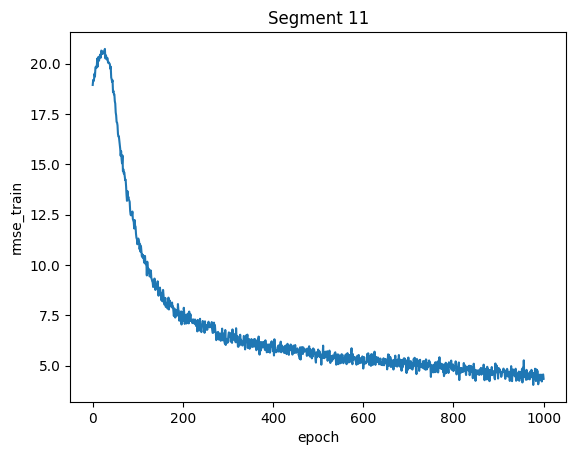

Took 0.20 seconds for prediction.

Сегмент: 11
Пользователь: 517762103
Рекомендовано: ['underwear', 'camera', 'dress', 'moccasins', 'sofa']
Куплено: {'clocks', 'headphone', 'alarm'}

Пользователь: 553490513
Рекомендовано: ['camera', 'dress', 'tablet', 'sofa', 'moccasins']
Куплено: {'wallet', 'alarm'}

Пользователь: 552161808
Рекомендовано: ['camera', 'video', 'dress', 'moccasins', 'tablet']
Куплено: {'acoustic'}

Пользователь: 541602381
Рекомендовано: ['camera', 'video', 'dress', 'sofa', 'tablet']
Куплено: {'acoustic'}

Пользователь: 554572832
Рекомендовано: ['underwear', 'camera', 'video', 'sandals', 'dress']
Куплено: {'headphone', 'keds', 'shoes', 'scarf'}

Пользователь: 517155552
Рекомендовано: ['camera', 'dress', 'tablet', 'sofa', 'moccasins']
Куплено: {'clocks', 'faucet', 'headphone', 'washer', 'refrigerators'}

Пользователь: 539083088
Рекомендовано: ['camera', 'dress', 'tablet', 'sofa', 'moccasins']
Куплено: {'alarm'}

Пользователь: 512596799
Рекомендовано: ['camera', 'video', 'd

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 11,5,0.06,0.08,0.03,0.15


---

Took 6.57 seconds for training.


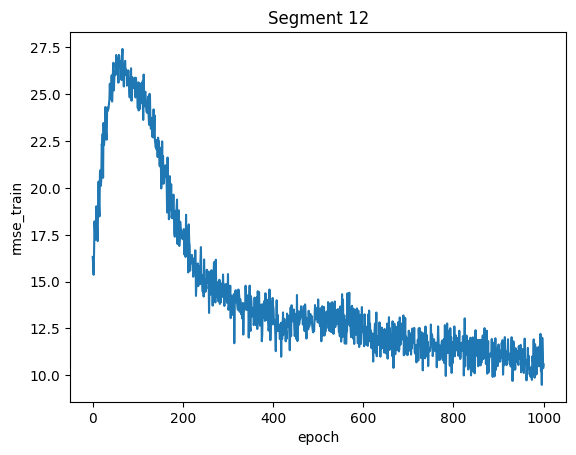

Took 0.12 seconds for prediction.

Сегмент: 12
Пользователь: 549348244
Рекомендовано: ['clocks', 'bed', 'dolls', 'shoes', 'printer']
Куплено: {'saw'}

Пользователь: 518882544
Рекомендовано: ['clocks', 'bed', 'printer', 'wallet', 'dolls']
Куплено: {'headphone', 'microwave'}

Пользователь: 561534085
Рекомендовано: ['bed', 'dolls', 'wallet', 'shoes', 'printer']
Куплено: {'sewing_machine', 'umbrella'}

Пользователь: 537735294
Рекомендовано: ['bed', 'mixer', 'dolls', 'shoes', 'printer']
Куплено: {'carriage'}

Пользователь: 513755338
Рекомендовано: ['clocks', 'bed', 'refrigerators', 'dolls', 'printer']
Куплено: {'generator'}

Пользователь: 515453227
Рекомендовано: ['clocks', 'mixer', 'bed', 'shoes', 'dolls']
Куплено: {'headphone', 'saw'}

Пользователь: 550306613
Рекомендовано: ['toys', 'clocks', 'mixer', 'underwear', 'shoes']
Куплено: {'toys', 'notebook', 'printer', 'refrigerators'}

Пользователь: 516505342
Рекомендовано: ['clocks', 'bed', 'dolls', 'printer', 'chair']
Куплено: {'microwave'}


,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,segment 12,5,0.09,0.09,0.02,0.09


---

In [12]:
###### Run main loop over all segments
prec = pd.DataFrame()
#plt=reload(plt)
%matplotlib inline
random.seed(45)
for seg in set(df['Segment']):
    ds = load_data(seg)
    data = ds[['userID', 'itemID', 'rating']]
    #data = data[data['userID']!=558364672]

    #instantiate the sparse matrix generation  
    am = AffinityMatrix(df = data, **header)

    #obtain the sparse matrix 
    X, _, _ = am.gen_affinity_matrix()
    Xtr, Xtst = numpy_stratified_split(X, ratio=0.8, seed=0)

    #print(f'train matrix size {Xtr.shape}')
    #print(f'test matrix size {Xtst.shape}')

    #First we initialize the model class
    model = RBM(
         # create a sorted list of all the unique ratings (of float type)
        possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])),
        visible_units=Xtr.shape[1],
        hidden_units=600, # number of hidden units
        training_epoch=1000,
        # minibatch_size=60, # size of the minibatch used in the random minibatches training; setting to 1 corresponds to
        # stochastic gradient descent, and it is considerably slower. Good performance is achieved
        # for a size of ~100.
        keep_prob=0.95,
        with_metrics=True, # if true, compute msre and accuracy during training
        debug=False,
    )
    if Xtr.shape[0] < 100:
        model.minibatch_size = Xtr.shape[0] // 2
    
    # Model Fit
    with Timer() as train_time:
        model.fit(Xtr)
    
    print("Took {:.2f} seconds for training.".format(train_time.interval))
    
    # Plot the train RMSE as a function of the epochs
    plt.xlabel('epoch')
    plt.ylabel('rmse_train')
    plt.title(f'Segment {seg}')
    plt.plot(model.rmse_train)#, labels='train', x_name='epoch', y_name='rmse_train')
    plt.show();

    # Model prediction on the test set Xtst.
    with Timer() as prediction_time:
        top_k =  model.recommend_k_items(Xtst)
    print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))

    top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
    test_df = am.map_back_sparse(Xtst, kind = 'ratings')
    top_k_df = top_k_df.fillna(0)
    id2name = ds[['itemID', 'category']].drop_duplicates()
    merged_df = top_k_df.merge(id2name, on='itemID', how='left')
    print(f'\nСегмент: {seg}')
    uid = 560178807 # 519382136, 513614418, 560178807
    #print(set(merged_df['userID']))
    if uid in merged_df['userID'].unique():
        #print(f'{uid} found')
        suser = uid
    else:
        suser = None
    for idx in random.sample(range(0, len(top_k_df)), 10):
        user_id = top_k_df['userID'].iloc[idx]
        if suser:
            user_id = suser
            suser = None
        print(f'Пользователь: {user_id}')
        filtered_df = merged_df[merged_df['userID'] == user_id].sort_values('prediction', ascending=False)[:5]
        print(f'Рекомендовано: {[x for x in filtered_df["category"]]}')
        print(f'Куплено: {set(dataset[(dataset["user_id"]==user_id) & (dataset["event_type"]=="purchase")]["category_code_level2"])}\n')

    segdata = ranking_metrics(
        data_size=f'segment {seg}',
        data_true=test_df,
        data_pred=top_k_df,
        K=5
    )
    
    prdf(segdata)
    prec = pd.concat([prec, segdata], ignore_index=True)
    display(Markdown('---'))

In [13]:
prec.drop(columns=['Dataset','K'], inplace=True)
prec.index.name = 'Segment'
#prec.reset_index(inplace=True)
#prec.rename(columns={'index': 'Segment'}, inplace=True)

In [14]:
print(f'Метрики ранжирования при k={K}')
prdf(prec.T)
print()
for col in prec.columns:
    print(f'{col}\t{prec[col].mean():.2f}')

Метрики ранжирования при k=50


Segment,0,1,2,3,4,5,6,7,8,9,10,11,12
MAP,0.09,0.20,0.09,0.27,0.12,0.10,0.09,0.04,0.03,0.05,0.06,0.06,0.09
nDCG@k,0.09,0.21,0.10,0.29,0.13,0.12,0.10,0.05,0.03,0.07,0.09,0.08,0.09
Precision@k,0.02,0.04,0.03,0.07,0.03,0.04,0.03,0.01,0.01,0.03,0.03,0.03,0.02
Recall@k,0.10,0.22,0.14,0.35,0.17,0.18,0.14,0.07,0.05,0.13,0.17,0.15,0.09



MAP	0.10
nDCG@k	0.11
Precision@k	0.03
Recall@k	0.15


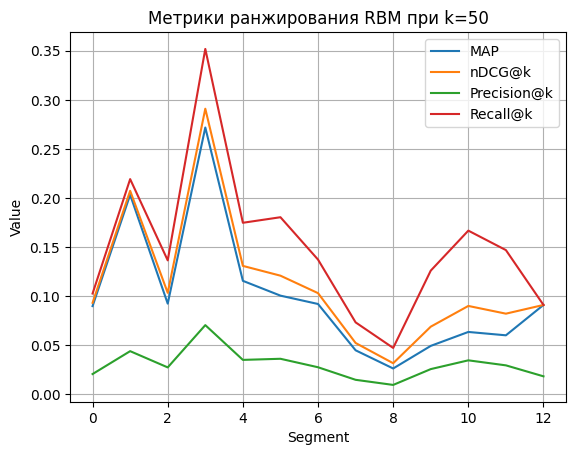

In [15]:
plot = prec.plot(xlabel='Segment', ylabel='Value', grid=True,title=f'Метрики ранжирования RBM при k={K}')
fig = plot.get_figure()
fig.savefig(f'rbm_k_{K}.png', dpi=300, bbox_inches='tight')

In [16]:
seconds=int(time.time() - start_time)
print("%d:%02d" % (seconds//60, seconds-60*(seconds//60),))

6:07


K=10
MAP	0.08
nDCG@k	0.09
Precision@k	0.03
Recall@k	0.10